In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning) # Borrar warnings

In [2]:
df = pd.read_csv("bank_transactions_data_2.csv")

In [3]:
df.sample(3)

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
1044,TX001045,AC00318,109.30,2023-08-02 16:52:15,Debit,Fort Worth,D000006,93.146.251.20,M020,Branch,56,Doctor,27,1,13510.11,2024-11-04 08:06:29
1464,TX001465,AC00132,130.93,2023-02-08 16:52:09,Credit,Houston,D000417,193.221.15.59,M061,Branch,28,Engineer,149,1,860.12,2024-11-04 08:11:18
2435,TX002436,AC00033,305.92,2023-12-06 16:42:18,Debit,El Paso,D000128,136.172.149.77,M057,ATM,72,Retired,88,1,1445.47,2024-11-04 08:08:28


- **TransactionID (ID de Transacción):** Identificador alfanumérico único para cada operación.
- **AccountID (ID de Cuenta):** Identificador único de la cuenta.
- **TransactionAmount (Monto de la Transacción):** Valor monetario involucrado en la operación.
- **TransactionDate (Fecha y Hora de la Transacción):** Marca de tiempo de la operación.
- **TransactionType (Tipo de Transacción):** Indica si la transacción es "Crédito" o "Débito".
- **Location (Ubicación):** Localización geográfica (ciudades de EE. UU.).
- **DeviceID (ID de Dispositivo):** Identificador del dispositivo utilizado.
- **IP Address (Dirección IP):** Dirección de red asociada a la transacción.
- **MerchantID (ID de Comercio/Proveedor):** Identificador único del comercio.
- **AccountBalance (Saldo de la Cuenta):** Saldo disponible luego de la transacción.
- **PreviousTransactionDate (Fecha de Transacción Anterior):** Marca de tiempo de la operación previa.
- **Channel (Canal):** Medio por el cual se efectuó (Online, ATM, Sucursal).
- **CustomerAge (Edad del Cliente):** Edad del titular de la cuenta.
- **CustomerOccupation (Ocupación del Cliente):** Ocupación declarada del cliente.
- **TransactionDuration (Duración de la Transacción):** Tiempo en segundos que tomó completarse.
- **LoginAttempts (Intentos de Inicio de Sesión):** Cantidad de intentos fallidos previos al acceso.


In [4]:
df.columns = ['ID_Trans', 'ID_Cuenta', 'Monto', 'Fecha', 'Tipo', 'Ubicacion', 'ID_Disposit', 'Direccion_IP', 'ID_Comercio', 'Canal', 'Edad_Cliente', 'Ocupacion', 'Duracion', 'Intentos_Login', 'Saldo', 'Fecha_Trans_Ant']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID_Trans         2512 non-null   object 
 1   ID_Cuenta        2512 non-null   object 
 2   Monto            2512 non-null   float64
 3   Fecha            2512 non-null   object 
 4   Tipo             2512 non-null   object 
 5   Ubicacion        2512 non-null   object 
 6   ID_Disposit      2512 non-null   object 
 7   Direccion_IP     2512 non-null   object 
 8   ID_Comercio      2512 non-null   object 
 9   Canal            2512 non-null   object 
 10  Edad_Cliente     2512 non-null   int64  
 11  Ocupacion        2512 non-null   object 
 12  Duracion         2512 non-null   int64  
 13  Intentos_Login   2512 non-null   int64  
 14  Saldo            2512 non-null   float64
 15  Fecha_Trans_Ant  2512 non-null   object 
dtypes: float64(2), int64(3), object(11)
memory usage: 314.1+ KB


In [6]:
df.duplicated().sum() # Mostrar número de filas duplicadas.

0

In [7]:
df.sample(3)

,ID_Trans,ID_Cuenta,Monto,Fecha,Tipo,Ubicacion,ID_Disposit,Direccion_IP,ID_Comercio,Canal,Edad_Cliente,Ocupacion,Duracion,Intentos_Login,Saldo,Fecha_Trans_Ant
548,TX000549,AC00041,124.59,2023-05-05 17:32:18,Debit,Charlotte,D000037,85.239.236.80,M025,Branch,27,Student,171,1,129.29,2024-11-04 08:09:21
49,TX000050,AC00471,22.01,2023-03-27 16:45:18,Credit,Sacramento,D000304,124.6.134.78,M055,Online,41,Engineer,175,1,1335.09,2024-11-04 08:06:31
2071,TX002072,AC00033,63.54,2023-05-22 18:23:18,Debit,Dallas,D000195,51.250.122.123,M045,ATM,26,Engineer,136,1,4401.78,2024-11-04 08:07:31


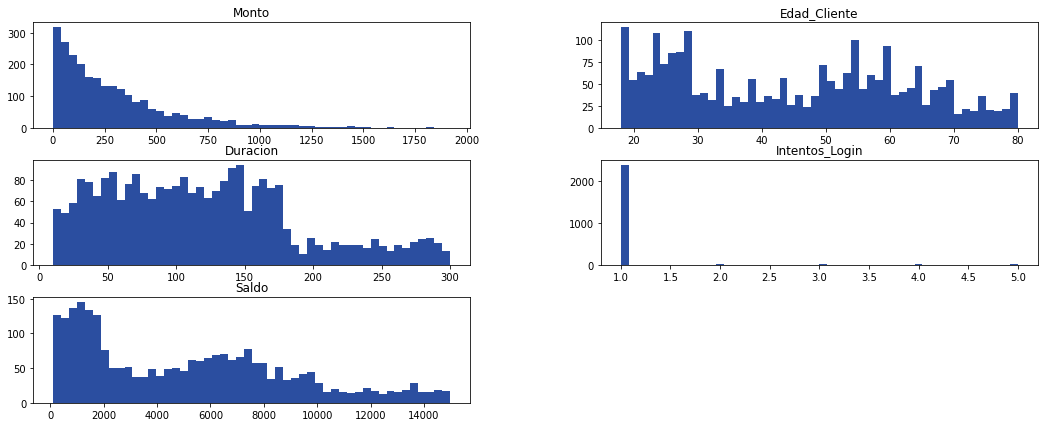

In [8]:
_= df.hist(grid=False, figsize=[18,7], color='#2B4EA0', bins=50)

In [9]:
df['Tipo'].value_counts()

Tipo
Debit     1944
Credit     568
Name: count, dtype: int64

In [10]:
# Como este dataset no tiene un campo objetivo como "Es fraude", a modo demostrativo creo uno aleatorio:
if 'Fraude' not in df.columns:
    df['Fraude'] = np.random.choice([0,1], size=len(df), p=[0.95, 0.05])  # 0=No Fraude, 1=Fraude

<AxesSubplot:>

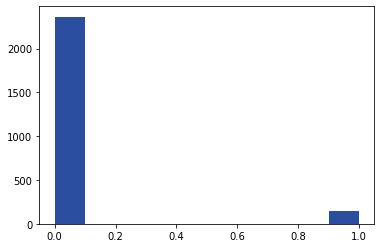

In [11]:
df['Fraude'].hist(grid=False, color='#2B4EA0')

In [12]:
df.sample(3)

,ID_Trans,ID_Cuenta,Monto,Fecha,Tipo,Ubicacion,ID_Disposit,Direccion_IP,ID_Comercio,Canal,Edad_Cliente,Ocupacion,Duracion,Intentos_Login,Saldo,Fecha_Trans_Ant,Fraude
2057,TX002058,AC00476,506.81,2023-12-20 16:17:24,Debit,Milwaukee,D000650,138.220.61.84,M091,ATM,59,Engineer,41,1,2757.23,2024-11-04 08:08:00,0
474,TX000475,AC00219,88.60,2023-02-14 17:01:44,Credit,Raleigh,D000403,170.54.231.239,M054,Branch,28,Student,105,1,246.57,2024-11-04 08:08:47,0
181,TX000182,AC00149,453.54,2023-04-19 16:36:03,Debit,Albuquerque,D000150,223.32.70.156,M017,ATM,58,Doctor,82,1,12046.30,2024-11-04 08:12:06,0


Comienzo a reemplazar los valores de los campos por variables numericas. En el primer caso, el campo 'Tipo' al ser posible dos unicos valores codifico asignando a un tipo de variable 0 y 1 a la otra. 

In [13]:
df['Tipo'].value_counts()

Tipo
Debit     1944
Credit     568
Name: count, dtype: int64

In [14]:
df['Tipo'] = df['Tipo'].replace({
    'Debit': 0,
    'Credit': 1,})

In [15]:
df['Canal'].value_counts()

Canal
Branch    868
ATM       833
Online    811
Name: count, dtype: int64

In [16]:
df['Canal'] = df['Canal'].replace({
    'Branch': 0,
    'ATM': 1,
    'Online': 2})

En el campo ubicación, para no generar tantas columnas, utilizo una codificacion por frecuencia.

In [17]:
df['Ubicacion'].value_counts().head(5) # Muestro solo los 7 mas frecuentes para no mostrar una fila con muchos valores.

Ubicacion
Fort Worth       70
Los Angeles      69
Oklahoma City    68
Charlotte        68
Tucson           67
Name: count, dtype: int64

In [18]:
# Codificación por Frecuencia, para no generar tantas columnas.
frecuencia_Ub = df['Ubicacion'].value_counts()
df['Ubicacion'] = df['Ubicacion'].map(frecuencia_Ub)

En el caso del campo 'Fecha' aplico un timestamp numérico que convierte una fecha completa a un entero, ese número representa cuántos segundos pasaron desde una fecha base estándar (generalmente es 1 de enero de 1970) El resultado final es un entero grande que expresa tiempo absoluto.

In [19]:
df['Fecha'] = pd.to_datetime(df['Fecha']) # Convierte el campo desde un string a datetime de pandas.
df['Fecha_ts'] = df['Fecha'].astype('int64') // 1e9 # Convierte a int64 dando la cantidad de nanosegundos desde 01/01/1970 luego divide por 1e9 para dejarlo en segundos.

In [20]:
# Tambien creo nuevas columnas extrayendo valores del campo fecha
df['año'] = df['Fecha'].dt.year
df['mes'] = df['Fecha'].dt.month
df['dia'] = df['Fecha'].dt.day
df['hora'] = df['Fecha'].dt.hour
df['minuto'] = df['Fecha'].dt.minute

In [21]:
df = df.drop('Fecha', axis=1) # Borro la columna fecha puesto que ya cree nuevas numericas para tal fin.

El campo ID_Disposit y Direccion_IP los voy a tener en cuenta, por eso debo convertirlos a numericos, usando codificación por frecuencia.

In [22]:
df['ID_Disposit'].value_counts().head(5)

ID_Disposit
D000697    9
D000203    9
D000548    9
D000663    9
D000142    9
Name: count, dtype: int64

In [23]:
freq = df['ID_Disposit'].value_counts()
df['ID_Disposit'] = df['ID_Disposit'].map(freq)

In [24]:
df['Direccion_IP'].value_counts().head(5)

Direccion_IP
200.136.146.93    13
49.31.186.82      11
166.79.195.157    10
9.230.41.239      10
173.135.78.201    10
Name: count, dtype: int64

In [25]:
freq = df['Direccion_IP'].value_counts()
df['Direccion_IP'] = df['Direccion_IP'].map(freq)

In [26]:
df['ID_Comercio'].value_counts().head(5) # Tambien solo muestro los 5 mas frecuentes.

ID_Comercio
M026    45
M066    34
M065    33
M013    33
M014    33
Name: count, dtype: int64

In [27]:
freq = df['ID_Comercio'].value_counts()
df['ID_Comercio'] = df['ID_Comercio'].map(freq)

In [28]:
df['Fecha_Trans_Ant'] = pd.to_datetime(df['Fecha_Trans_Ant'])
df['Fecha_Trans_Ant'] = df['Fecha_Trans_Ant'].astype('int64') // 1e9

In [29]:
df.sample()

,ID_Trans,ID_Cuenta,Monto,Tipo,Ubicacion,ID_Disposit,Direccion_IP,ID_Comercio,Canal,Edad_Cliente,...,Intentos_Login,Saldo,Fecha_Trans_Ant,Fraude,Fecha_ts,año,mes,dia,hora,minuto
226,TX000227,AC00212,163.68,0,59,4,8,25,0,41,...,1,10090.05,1.730708e+09,0,1.695918e+09,2023,9,28,16,20


In [30]:
df['Ocupacion'].value_counts()

Ocupacion
Student     657
Doctor      631
Engineer    625
Retired     599
Name: count, dtype: int64

In [31]:
df['Ocupacion'] = df['Ocupacion'].replace({
    'Student': 0,
    'Doctor': 1,
    'Engineer': 2,
    'Retired': 3})

In [32]:
df = df.drop(['ID_Trans'], axis=1)
df = df.drop(['ID_Cuenta'], axis=1)

In [33]:
df.sample(5)

,Monto,Tipo,Ubicacion,ID_Disposit,Direccion_IP,ID_Comercio,Canal,Edad_Cliente,Ocupacion,Duracion,Intentos_Login,Saldo,Fecha_Trans_Ant,Fraude,Fecha_ts,año,mes,dia,hora,minuto
1699,152.34,0,65,6,5,24,0,55,1,115,1,6853.51,1.730708e+09,0,1.697131e+09,2023,10,12,17,10
2507,856.21,1,60,3,1,15,0,33,1,109,1,12690.79,1.730708e+09,0,1.682529e+09,2023,4,26,17,9
1229,17.21,0,65,5,3,31,2,23,0,219,1,914.16,1.730708e+09,0,1.703525e+09,2023,12,25,17,18
317,350.94,0,60,3,5,33,1,20,0,64,1,221.56,1.730708e+09,0,1.698686e+09,2023,10,30,17,17
2495,271.22,1,51,4,4,22,1,45,1,87,1,6863.02,1.730708e+09,0,1.680538e+09,2023,4,3,16,7


#### Creacion de nuevas caracteristicas con los datos:

Creo nueva columna donde para cada fila veo cuánto representa el Monto respecto del Saldo disponible. (El +1 es para evitar errores cuando el saldo es igual a 0). Si el valor es alto (ej: 2, 5, 10) significa que el monto de la transacción es mucho mayor que el saldo. Si el valor está cerca de 1 el monto es parecido al saldo y si el valor es menor a 1 quiere decir que el monto es más chico que el saldo. Cuando un monto supera el saldo disponible suelen ser operaciones menos comunes y a veces están asociadas a un comportamiento irregular.

In [34]:
df['monto_vs_saldo'] = df['Monto'] / (df['Saldo'] + 1) 

Esta nueva caracteristica, mide cuántas ubicaciones distintas usa cada dispositivo. La nueva columna identifica cuantas ubicaciones diferentes utilizo ese dispositivo en todo el historial, para analizar que un dispositivo que siempre opera desde una sola ubicación puede ser normal en cambio un dispositivo que aparece con muchas ubicaciones distintas puede indicar uso compartido, posible robo de credenciales, comportamiento inusual.

In [35]:
# Agrupo por ID_Disposit, dentro de cada grupo calcula el numero de ubicaciones unicas (nunique) usadas por ese dispositivo
df['ubicaciones_distintas'] = df.groupby('ID_Disposit')['Ubicacion'].transform('nunique')

La proxima nueva caracteristica, suma cuántas veces aparece una dirección IP en el historial del dispositivo. En definitiva muestra cuantas transacciones (o registros) tiene ese dispositivo en total.

In [36]:
# Agrupo por ID_Disposit, dentro de cada grupo calculo la direccion de IP 
df['IP.Freqxcliente'] = df.groupby('ID_Disposit')['Direccion_IP'].transform('count')

Un dispositivo que cambia IP muy seguido suele ser sospechoso, puede indicar VPN, proxys, movimientos fuera del patrón habitual o un acceso no autorizado. El primer registro de cada dispositivo siempre marca 1 (no hay historial anterior), lo cual es normal: dispositivos nuevos también representan mayor riesgo. En resumen indica si el dispositivo está usando una IP diferente de la inmediatamente anterior.

In [37]:
# Agrupo los datos por ID_Disposit, luego comparar la IP actual con la IP anterior del mismo dispositivo.
#df['IP_uso.nueva'] = (df.groupby('ID_Disposit')['Direccion_IP']
 #                   .transform(lambda x: x != x.shift(1))).astype(int)

Cuántas IPs únicas usó cada dispositivo porque se da que usuarios normales usan entre 1 y 3 IPs generalmente, los que hacen fraudes suelen usar muchas IPs (por uso de VPNs, proxys).

In [38]:
# Agrupo por ID_Disposit, dentro de cada grupo calcula el numero de Direccion_IP unicas (nunique) usadas por ese dispositivo
#df['IP_unicas'] = df.groupby('ID_Disposit')['Direccion_IP'].transform('nunique')

Esta nueva caracteristica, crea una señal binaria que indica si una operación tiene más intentos de login que el usuario promedio. Porque los estafadores suelen probar contraseñas repetidamente, hacen intentos fallidos antes de lograr acceso.

In [39]:
# Calcula la mediana de Intentos_Login, luego compara cada fila con la mediana y genera 0 y 1 en funcion de si tiene o no mas de 1 intento.
# 0 seria un rango normal, 1 cuando tiene mas de 1 intento de login.
#df['Login_rep'] = (df['Intentos_Login'] > df['Intentos_Login'].median()).astype(int)

In [40]:
from sklearn.ensemble import IsolationForest

In [41]:
data = df
X = data # Defino solo "X" y no "y" porque isolation forest solo necesita X donde estaran las variables donde quiero buscar anomalias.

In [42]:
model = IsolationForest(n_estimators=100,
                        contamination=0.15, # 10% de los datos se consideran anomalías
                        random_state=42)

In [43]:
model.fit(X)

IsolationForest(contamination=0.15, random_state=42)

In [44]:
print("3. Realizando predicciones...")

# El método 'predict' clasifica cada punto como Inlier (1) u Outlier (-1).
y_pred = model.predict(X)

# El método 'decision_function' proporciona la puntuación de anomalía:
# Valores más bajos indican una mayor probabilidad de ser una anomalía.
scores = model.decision_function(X)

3. Realizando predicciones...


In [45]:
# Lo convierto a 0/1 para que sea más claro:
#   0 = normal
#   1 = anomalía
y_pred = pd.Series(y_pred).map({1: 0, -1: 1})


In [46]:
anomalies = X[y_pred == -1]
normal_data = X[y_pred == 1]

In [47]:
y_pred.value_counts()

0    2135
1     377
Name: count, dtype: int64

In [48]:
df['Anomalia'] = y_pred

In [49]:
df.sample(3)

,Monto,Tipo,Ubicacion,ID_Disposit,Direccion_IP,ID_Comercio,Canal,Edad_Cliente,Ocupacion,Duracion,...,Fecha_ts,año,mes,dia,hora,minuto,monto_vs_saldo,ubicaciones_distintas,IP.Freqxcliente,Anomalia
866,98.71,0,70,3,6,32,1,32,1,117,...,1.695059e+09,2023,9,18,17,41,0.009777,22,435,0
194,488.54,0,60,4,5,25,0,52,2,132,...,1.688406e+09,2023,7,3,17,47,0.065246,22,596,0
1814,18.30,0,61,9,4,26,2,48,2,155,...,1.676305e+09,2023,2,13,16,21,0.004900,17,63,1


In [50]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(df['Fraude'], df['Anomalia']))
print(classification_report(df['Fraude'], df['Anomalia']))


[[2091  273]
 [  44  104]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2364
           1       0.28      0.70      0.40       148

    accuracy                           0.87      2512
   macro avg       0.63      0.79      0.66      2512
weighted avg       0.94      0.87      0.90      2512



In [51]:
df[df['Anomalia'] == 1].head(5)

,Monto,Tipo,Ubicacion,ID_Disposit,Direccion_IP,ID_Comercio,Canal,Edad_Cliente,Ocupacion,Duracion,...,Fecha_ts,año,mes,dia,hora,minuto,monto_vs_saldo,ubicaciones_distintas,IP.Freqxcliente,Anomalia
13,781.76,0,63,4,5,31,1,26,0,123,...,1.700498e+09,2023,11,20,16,39,4.099638,22,596,1
20,59.32,0,69,1,5,26,0,71,3,38,...,1.677602e+09,2023,2,28,16,36,0.010313,20,72,1
22,52.20,0,61,9,9,17,2,39,2,120,...,1.686078e+09,2023,6,6,18,54,0.005816,17,63,1
26,246.93,0,64,8,5,25,1,23,0,158,...,1.681749e+09,2023,4,17,16,37,0.366175,19,120,1
36,78.13,0,55,5,4,33,0,26,0,145,...,1.700586e+09,2023,11,21,16,58,0.086656,22,435,1


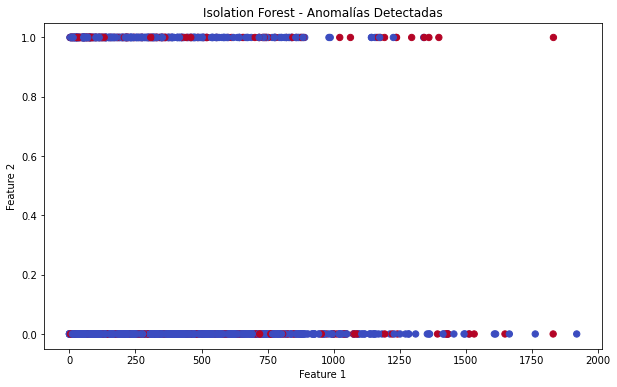

In [52]:
import matplotlib.pyplot as plt

X_np = X.to_numpy()

plt.figure(figsize=(10,6))
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_pred, cmap="coolwarm", s=40)
plt.title("Isolation Forest - Anomalías Detectadas")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
